## **Setting Up the Data Warehouse**
Estimated runtime: ~2 minutes

Installations required:
- [MySQL](https://dev.mysql.com/downloads/installer/)
- pandas, sqlalchemy, mysql-connector-python (pip)

In [1]:
# Database configuration
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': '1234567', # Replace with your MySQL root password
    'port': '3306',  # Default MySQL port
    'database': 'Group4MCO1'  
}

The `SteamDB` class will handle creation of a MySQL database with our group's schema.

In [2]:
from SteamDB import SteamDB

db = SteamDB(db_config=db_config)
db.create_steam_db()

CSV loaded into DataFrame.
Connected to MySQL server.
Connected to database 'Group4MCO1'.
SteamDB builder executed successfully!
Binary encodings added to table 'dim_os'


Querying the database to check if the schema was created correctly.

In [3]:
db.execute_sql("DESCRIBE dim_game")

                 Field          Type Null  Key Default Extra
0               gameID           int   NO  PRI    None      
1                 name  varchar(255)   NO         None      
2          releaseDate          date  YES         None      
3          requiredAge           int  YES         None      
4         aboutTheGame          text  YES         None      
5           websiteURL  varchar(255)  YES         None      
6           supportURL  varchar(255)  YES         None      
7         supportEmail  varchar(255)  YES         None      
8   supportedLanguages          text  YES         None      
9   fullAudioLanguages          text  YES         None      
10     headerImageHREF  varchar(255)  YES         None      
11          categories          text  YES  MUL    None      
12                tags          text  YES  MUL    None      
13              genres          text  YES  MUL    None      


In [4]:
db.execute_sql("DESCRIBE dim_company")
db.execute_sql("DESCRIBE dim_os")

       Field          Type Null  Key Default           Extra
0  companyID           int   NO  PRI    None  auto_increment
1  developer  varchar(255)  YES         None                
2  publisher  varchar(255)  YES         None                
            Field        Type Null  Key Default Extra
0            osID  varchar(3)   NO  PRI    None      
1  windowsSupport  tinyint(1)   NO         None      
2      macSupport  tinyint(1)   NO         None      
3    linuxSupport  tinyint(1)   NO         None      


In [5]:
db.execute_sql("DESCRIBE fact_gamemetrics")

                     Field          Type Null  Key Default Extra
0                   gameID           int  YES  MUL    None      
1                companyID           int  YES  MUL    None      
2                     osID    varchar(3)  YES  MUL    None      
3                    price         float  YES         None      
4                  peakCCU           int  YES         None      
5         achievementCount           int  YES         None      
6   averagePlaytimeForever         float  YES         None      
7    medianPlaytimeForever         float  YES         None      
8          estimatedOwners  varchar(255)  YES         None      
9                 dlcCount           int  YES         None      
10         metacriticScore           int  YES         None      
11               userScore         float  YES         None      
12                positive           int  YES         None      
13                negative           int  YES         None      
14               scoreRan

### ETL Pipelines
**`SteamDB.populate_steam_db()` performs the following transformations on the data source `games.csv`:**
- Rename all columns to match our tables' column names 
- Change the format of `Release date` from "MMMM DD, YYYY" to "YYYY-MM-DD" for MySQL DATE type

**...on the dimension table `dim_games`:**
- Project 14 columns from the data source, including 3 FULLTEXT indices (`Categories`, `Genres`, `Tags`)
- Select entries with non-NULL and non-empty strings in `Name`
- Select unique combinations of subset (`gameID`, `name`)
- Truncate `About the game` and `Support url` to 255 characters

**...on the dimension table `dim_company`:**
- Project 2 columns from the data source, `Developer` and `Publisher`
- Select unique combinations of all columns

**...on the fact table `fact_gamemetrics`:**
- Project 14 columns from the data source
- Select entries with non-NULL and non-empty strings in `Name`
- Assign `companyID` to each row based on a data source INNER JOIN with `dim_company`
- Assign `osID` through binary encoding of `Windows`, `Mac`, and `Linux` -- in that order

In [6]:
db.populate_steam_db()

Data written to dim_game successfully and transaction committed.
Data written to dim_company successfully and transaction committed.
Data written to fact_gamemetrics successfully and transaction committed.


In [7]:
# Check the first few rows of the fact table
db.execute_sql("SELECT * FROM fact_gamemetrics ORDER BY averagePlaytimeForever DESC LIMIT 5")

    gameID  companyID osID  price  peakCCU  achievementCount  \
0  1071100       4737  100  16.99      199                 0   
1  1055010       9411  100   3.99       67                 0   
2  1195830      25555  100   0.00       13                 0   
3   707590      17498  100   0.00        3               315   
4   404580      18922  110   0.00        0                20   

   averagePlaytimeForever  medianPlaytimeForever estimatedOwners  dlcCount  \
0                145727.0               145727.0   20000 - 50000         0   
1                104238.0               208473.0  50000 - 100000         0   
2                 90351.0                90351.0  50000 - 100000         3   
3                 76068.0                76068.0   20000 - 50000         2   
4                 68357.0               136629.0  50000 - 100000         0   

   metacriticScore  userScore  positive  negative scoreRank  recommendations  
0                0        0.0       426        43      None        

## **OLAP and Visualization**

In [15]:
# Libraries for visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def display_scrollable_table(df: pd.DataFrame, vertical=False):
    """
    Function to display a Pandas DataFrame as a scrollable table with x-overflow.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to display.
    """
    table_html = df.to_html(classes='scroll-table', index=False)
    
    # Set height for vertical scrolling if needed
    height_style = "height: 300px;" if vertical else "height: auto;"
    
    display(HTML(f"""
    <style>
        .scroll-table {{
            display: block;
            overflow-x: auto;
            {height_style}
            overflow-y: {"auto;" if vertical else "hidden;"}
            white-space: nowrap;
        }}
        .scroll-table table {{
            width: 100%;
            border-collapse: collapse;
        }}
        .scroll-table th, .scroll-table td {{
            padding: 8px;
            text-align: left;
            border-bottom: 1px solid #ddd;
        }}
    </style>
    {table_html}"""))
    
def apply_to_column(lambda_, data_frame: pd.DataFrame, column_name):
    data_frame[column_name] = data_frame[column_name].apply(lambda x: lambda_(x))
    
def add_commas_to_longN(n):
    return f"{int(n):,}"

**OLAP #1: Revenue by Company**  
Purpose: Estimate the revenue generated by different developers and publishers.

Find which companies are generating the most revenue by *rolling-up* the involved `developer` and `publisher`.

In [16]:
res = db.execute_sql("""
    SELECT c.developer, c.publisher, SUM(f.price * f.estimatedOwners) AS estimatedRevenue
    FROM fact_GameMetrics f
    JOIN dim_game g ON f.gameID = g.gameID
    JOIN dim_company c ON f.companyID = c.companyID
    GROUP BY c.developer, c.publisher
    ORDER BY estimatedRevenue DESC
    LIMIT 20
""", with_results=True)
apply_to_column(add_commas_to_longN, data_frame=res, column_name="estimatedRevenue")
display_scrollable_table(res)

developer,publisher,estimatedRevenue
Game Science,Game Science,"2,999,500,083"
Amazon Games,Amazon Games,"1,999,500,083"
Valve,Valve,"1,364,569,971"
FromSoftware Inc.,"FromSoftware Inc.,Bandai Namco Entertainment","1,199,800,033"
CD PROJEKT RED,CD PROJEKT RED,"1,010,294,533"
"CAPCOM Co., Ltd.","CAPCOM Co., Ltd.","972,196,008"
Bethesda Game Studios,Bethesda Softworks,"964,724,999"
Facepunch Studios,Facepunch Studios,"800,099,833"
"CREATIVE ASSEMBLY,Feral Interactive (Mac),Feral Interactive (Linux)","SEGA,Feral Interactive (Mac),Feral Interactive (Linux)","714,835,014"
Ubisoft Montreal,Ubisoft,"674,675,996"


**OLAP #2: Cross-System Compatibility Revenue Comparison**  
Purpose: Compare the revenue and playtime for games supporting multiple platforms (Windows, Mac, Linux).

Discover how cross-platform games perform by slicing `osID` to group by systems supported and dicing across metrics `SUM(price * estimatedOwners)` and `AVG(averagePlayTimeForever)`.

> osID is interpreted as [Windows][Mac][Linux]

In [17]:
res = db.execute_sql("""
    SELECT os.osID, SUM(f.price * f.estimatedOwners) AS totalRevenue, AVG(f.averagePlaytimeForever) AS avgPlaytime
    FROM fact_GameMetrics f
    JOIN dim_OS os ON f.osID = os.osID
    GROUP BY os.osID
    ORDER BY totalRevenue DESC
""", with_results=True)
y = res['totalRevenue'] # For visualization purposes
apply_to_column(add_commas_to_longN, data_frame=res, column_name="totalRevenue")
display_scrollable_table(res)

osID,totalRevenue,avgPlaytime
100,"43,008,091,229",82.694550
111,"8,997,528,875",142.050445
110,"4,755,858,975",121.180269
101,"903,791,498",74.268617
010,"1,918,099",1553.960000
001,"599,799",4.833333
011,"249,499",341.000000


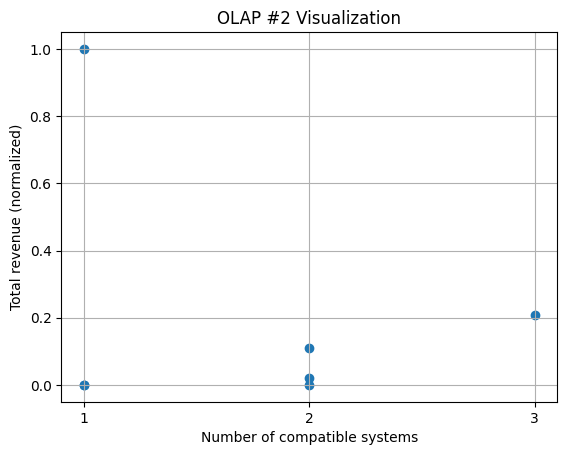

In [11]:
def sum_of_digits(num):
    return sum(int(digit) for digit in str(num))

res['cross-compat'] = res['osID'].apply(sum_of_digits)

x_min, x_max = np.min(res['cross-compat']), np.max(res['cross-compat'])
x_normalized = 1 + (res['cross-compat'] - x_min) * (3 - 1) / (x_max - x_min)

y_min, y_max = np.min(y), np.max(y)
y_normalized = (y - y_min) / (y_max - y_min)

plt.scatter(x_normalized, y_normalized)
plt.xticks([1,2,3])

plt.xlabel('Number of compatible systems')
plt.ylabel('Total revenue (normalized)')
plt.title('OLAP #2 Visualization')

plt.grid()
plt.show()

**OLAP #3: Revenue by Genre and Release Year**

Makes use of drill down since it breaks the revenue down by genre and release year. Gives more detail to the group.

In [13]:
unique_genres = ["Casual", "Video Production", "Tutorial", "Indie", "Strategy", "Sports", "Design & Illustration", "Simulation", "Free to Play", "Education", "Early Access", "Racing", "Gore", "Documentary", "Game Development", "RPG", "Photo Editing", "Web Publishing", "Movie", "Adventure", "360 Video", "Short", "Action", "Massively Multiplayer", "Software Training", "Free To Play", "Animation & Modeling", "Utilities", "Episodic", "Audio Production", "Nudity", "Accounting", "Violent", "Sexual Content"]
res = []

for genre in unique_genres:
    temp = db.execute_sql(f"""
        SELECT YEAR(g.releaseDate) AS releaseYear, SUM(f.price * f.estimatedOwners) AS totalRevenue
        FROM fact_GameMetrics f
        JOIN dim_game g ON f.gameID = g.gameID
        WHERE MATCH(g.genres) AGAINST('{genre}' IN NATURAL LANGUAGE MODE)
        GROUP BY YEAR(g.releaseDate)
        ORDER BY totalRevenue DESC
    """, with_results=True)
    for i in range(temp['releaseYear'].count()):
        res += [{'genre': genre, 'releaseYear': temp['releaseYear'][i], 'totalRevenue': f"{int(temp['totalRevenue'][i]):,}"}]
display_scrollable_table(pd.DataFrame(res), vertical=True)

genre,releaseYear,totalRevenue
Casual,2021,"573,175,195"
Casual,2020,"554,497,297"
Casual,2016,"550,650,792"
Casual,2018,"497,957,596"
Casual,2019,"357,945,299"
Casual,2014,"319,265,193"
Casual,2015,"282,351,695"
Casual,2017,"273,890,495"
Casual,2022,"218,929,598"
Casual,2012,"141,295,597"


### Templates for Querying SteamDB
To the user who will write their own SQL queries for the data warehouse, please keep in mind the following format:

In [ ]:
# Sample function for applying lambda to a column
def foo(val):
    return val**2

In [ ]:
# SteamDB.execute_sql() returns pandas.DataFrame if parameter `with_results` is True. This parameter is set to False by default.
result_df = db.execute_sql("""
    -- INSERT SQL QUERY HERE
""", with_results=True)

# Perform any formatting using apply_to_column()
apply_to_column(foo, data_frame=result_df, column_name="")

# Display using this function, which accepts a DataFrame input, for a *beautifully*-formatted table
display_scrollable_table(result_df)


> Update: if `with_results` parameter is set to `True`, an output CSV file will be written to the directory `queries/output`.